In [14]:
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import scvelo as scv
from tqdm.notebook import tqdm
from matplotlib_venn import venn2, venn3

In [17]:
h2m_tab = pd.read_csv('../biomart/human_to_mouse_biomart_export.csv').set_index('Gene name')
m2h_tab = pd.read_csv('../biomart/mouse_to_human_biomart_export.csv').set_index('Gene name')

In [10]:
mouse_data = scv.datasets.pancreas()

# Visualizations

In [11]:
human_data = sc.datasets.pbmc3k()

In [12]:
human_data

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [13]:
mouse_data

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

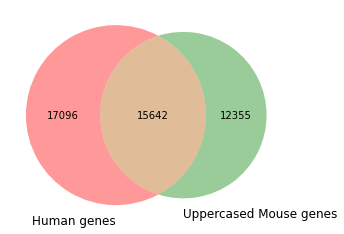

In [15]:
human_set = set(human_data.var_names)
mouse_set = set([x.upper() for x in mouse_data.var_names])

venn2([human_set, mouse_set], ('Human genes', 'Uppercased Mouse genes'))
pl.show()

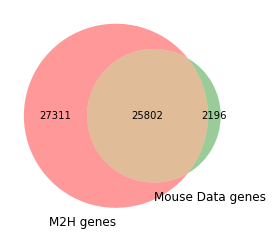

In [18]:
mouse_data_set = set(mouse_data.var_names)
m2h_set = set(m2h_tab.index)

venn2([m2h_set, mouse_data_set], ('M2H genes', 'Mouse Data genes'))
pl.show()


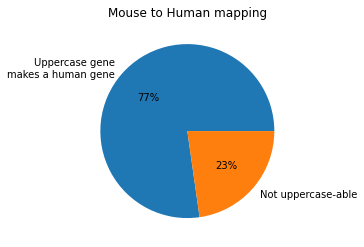

In [19]:
upperable_genes = [x for x in mouse_data.var_names if x.upper() in human_set]
pl.pie([len(m2h_set), len(upperable_genes)], 
       labels=['Uppercase gene\nmakes a human gene', 'Not uppercase-able'], autopct='%.0f%%')
pl.title('Mouse to Human mapping')
pl.show()

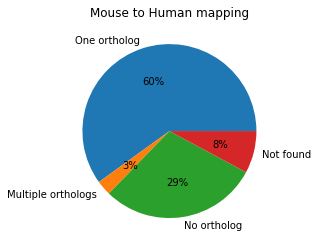

In [21]:
pl.pie([len(m2h_direct), len(m2h_multiple), len(m2h_no_hit), len(m2h_no_index)], 
       labels=['One ortholog', 'Multiple orthologs', 'No ortholog', 'Not found'], autopct='%.0f%%')
pl.title('Mouse to Human mapping')
pl.show()

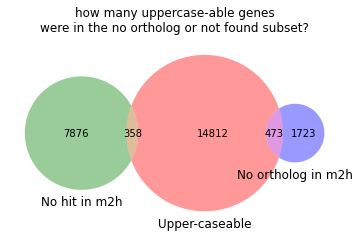

In [22]:
# how many uppercase-able genes were in the no ortholog or not found subset?

A = set(upperable_genes)
B = set(m2h_no_hit)
C = set(m2h_no_index)

venn3([A,B,C], ('Upper-caseable', 'No hit in m2h', 'No ortholog in m2h'))
pl.title('how many uppercase-able genes\nwere in the no ortholog or not found subset?')

pl.show()

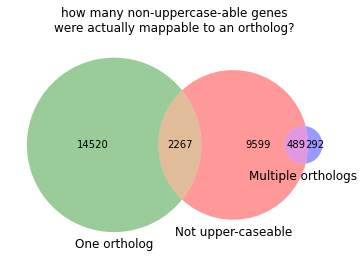

In [23]:
# how many non-uppercase-able genes were actually mappable to an ortholog?
non_upperable_genes = [x for x in mouse_data.var_names if x.upper() not in human_set]

A = set(non_upperable_genes)
B = set(m2h_direct.keys())
C = set(m2h_multiple.keys())

venn3([A,B,C], ('Not upper-caseable', 'One ortholog', 'Multiple orthologs'))
pl.title('how many non-uppercase-able genes\nwere actually mappable to an ortholog?')
pl.show()

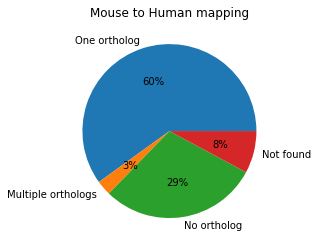

In [24]:
pl.pie([len(m2h_direct), len(m2h_multiple), len(m2h_no_hit), len(m2h_no_index)], 
       labels=['One ortholog', 'Multiple orthologs', 'No ortholog', 'Not found'], autopct='%.0f%%')
pl.title('Mouse to Human mapping')
pl.show()

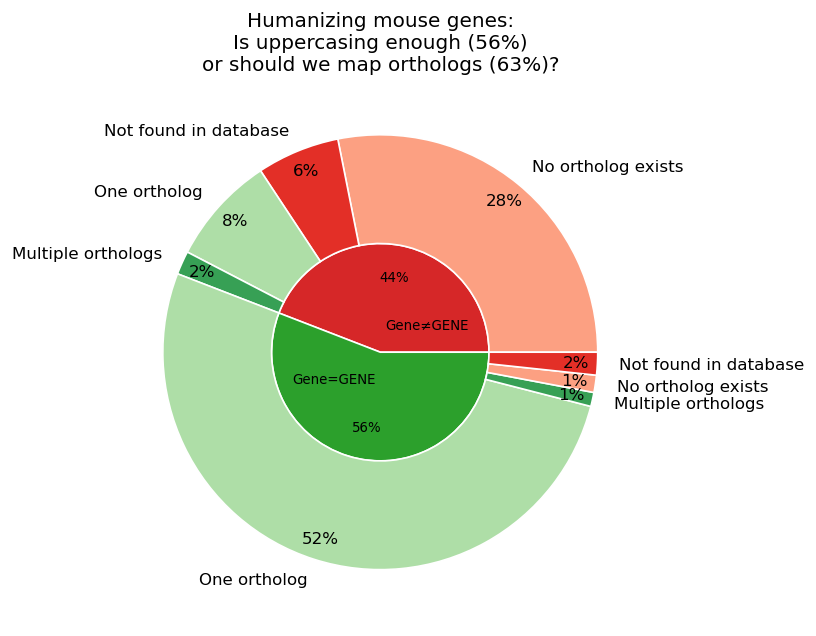

In [25]:
pl.figure(dpi=120, figsize=[6,6])
size=0.5
wedgeprops=dict(width=size, edgecolor='w')

from matplotlib.cm import get_cmap
Greens = get_cmap('Greens')
Reds = get_cmap('Reds')

pl.pie([len(non_upperable_genes), len(upperable_genes)], wedgeprops=wedgeprops, radius=1-size,
       autopct='%0.0f%%', pctdistance=.7,
       labels=['Gene≠GENE', 'Gene=GENE'], labeldistance=0.25, textprops={'fontsize': 8}, colors=['tab:red', 'tab:green'])

A1 = np.isin(list(m2h_direct.keys()), non_upperable_genes).sum()
A2 = np.isin(list(m2h_multiple.keys()), non_upperable_genes).sum()
A3 = np.isin(m2h_no_hit, non_upperable_genes).sum()
A4 = np.isin(m2h_no_index, non_upperable_genes).sum()

B1 = np.isin(list(m2h_direct.keys()), upperable_genes).sum()
B2 = np.isin(list(m2h_multiple.keys()), upperable_genes).sum()
B3 = np.isin(m2h_no_hit, upperable_genes).sum()
B4 = np.isin(m2h_no_index, upperable_genes).sum()

pl.pie([A3, A4, A1, A2, B1, B2, B3, B4], wedgeprops=wedgeprops, 
       labels=['No ortholog exists', 'Not found in database', 'One ortholog', 'Multiple orthologs', 'One ortholog', 'Multiple orthologs', 'No ortholog exists', 'Not found in database'],
       autopct='%0.0f%%', pctdistance=.9,
       colors=[Reds(1/3), Reds(2/3)] + [Greens(1/3), Greens(2/3)] *2 + [Reds(1/3), Reds(2/3)]
      )
pl.title('Humanizing mouse genes:\nIs uppercasing enough (56%)\nor should we map orthologs (63%)?')
pl.show()

# Translation

In [136]:
def check_orthologs(var_names, tab=m2h_tab):
    direct = {}
    multiple = {}
    no_hit = []
    no_index = []
    for gene in tqdm(var_names):
        if gene in tab.index:
            # gene in index
            x = tab['Human gene name'].loc[gene]
            if isinstance(x, pd.Series):
                # multiple hits
                vals = pd.unique(x.values)
                vals = vals[~pd.isna(vals)]
                if len(vals)>1:
                    # multiple actual hits
                    multiple[gene]=vals
                elif len(vals)==1:
                    # one actual hit
                    direct[gene] = vals[0]
                else:
                    # actually no hit (t'was multiple nans)
                    no_hit.append(gene)
            elif pd.isna(x):
                # no hit
                no_hit.append(gene)
            else:
                # one hit
                direct[gene] = x
        else:
            # gene not in index
            no_index.append(gene)
    return direct, multiple, no_hit, no_index

def translate_direct(adata, direct, no_index):
    # direct hits can be used as is
    # for those with no entry in the database we assume that uppercase-ing works out as a good guess
    # (after excluding some gene symbols which usually do not map)
    guess_genes = [
    x for x in no_index if
    x[:2] != 'Gm' and
    'Rik' not in x and
    x[:2] != 'RP' and
    'Hist' not in x and
    'Olfr' not in x and
    '.' not in x]
    ndata = adata[:, list(direct.keys()) + guess_genes].copy()
    ndata.var['original_gene_symbol'] = list(direct.keys()) + guess_genes
    ndata.var_names = list(direct.values()) + [m.upper() for m in guess_genes]
    return ndata
    
def translate_multiple(adata, original_data, multiple):
    # multiple hits are tricky:
    # we will add the counts of a mouse gene to ALL the homologs it maps to.
    # Unfortunately this takes pretty long (~10mins for ~1000 genes)
    from scipy.sparse import csr_matrix, hstack
    X = adata.X
    var = adata.var
    for mgene, hgenes in tqdm(multiple.items()):
        for hgene in hgenes:
            if hgene not in list(var.index):
                # Add counts to new gene
                X = csr_matrix(hstack((X, original_data[:, mgene].X)))
                var.loc[hgene] = None
                var.loc[hgene, 'original_gene_symbol'] = 'multiple'
            else:
                # Add counts to existing gene
                idx = np.where(np.array(list(var.index))==hgene)[0][0]
                X[:, idx] += original_data[:, mgene].X
    return sc.AnnData(X, adata.obs, var, adata.uns, adata.obsm)    


def translate(adata, tab=m2h_tab):
    direct, multiple, no_hit, no_index = check_orthologs(adata.var_names, tab=m2h_tab)
    
    # for those with an entry but no ortholog we assume that there really is no known ortholog
    # which means we ignore genes in m2h_no_hit
    bdata = translate_direct(adata, direct, no_index)
    bdata = translate_multiple(bdata, adata, multiple)
    return bdata

In [137]:
humanized_data = translate(mouse_data, tab=m2h_tab)

  0%|          | 0/27998 [00:00<?, ?it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [138]:
humanized_data

AnnData object with n_obs × n_vars = 3696 × 18435
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes', 'original_gene_symbol'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'

In [ ]:
# todo: collapse resulting duplicate genes